# 1. Batch normalization (2 points)

Please make use of the model code from Homework 5 question 2 as you work on this question.

1. If your model didn't use batch normalization, add it. If it already had batch normalization, remove it. How does the performance change? Please experiment with different learning rate values, since batch normalization can allow a different range of learning rates to work. You are welcome to write your own batch norm implementaiton or use a pre-existing one from mxnet or pytorch.
1. Plot the squared L2 norm of gradients with respect to parameters over the course of training with and without batch normalization. To do this, you will need to compute the gradient of the loss over some data with respect to each parameter, square these gradients, and sum the result across all parameters. You can compute this value at each training step, or after each epoch. What difference does batch normalization make in terms of the squared L2 norm of gradients?

## 1.1 Batch Normalization - 
### fixes Unstable Gradients, convergence is faster which means achieves the same accuracy faster. With batch normalization, the gradients decrease steadily, there is less zig-zag pattern.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
import sys
sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks')
import time
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
# From local helper files
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
#from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import get_dataloaders_cifar10, UnNormalize

Mounted at /content/drive


In [2]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 123
BATCH_SIZE = 256
NUM_EPOCHS = 20
NUM_CLASSES = 10
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
set_all_seeds(RANDOM_SEED)

In [3]:
##########################
### CIFAR-10 DATASET
##########################


'''train_transforms = torchvision.transforms.Compose([
    
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])

test_transforms = torchvision.transforms.Compose([
         
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])'''

train_transforms = transforms.Compose([
            #util.Cutout(num_cutouts=2, size=8, p=0.8),
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
test_transforms = transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                             ])


train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    num_workers=2)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Image batch dimensions: torch.Size([256, 3, 32, 32])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([4, 7, 4, 6, 2, 6, 9, 7, 3, 0])


In [4]:
def compute_accuracy(model, data_loader, device):
    with torch.no_grad():
        correct_pred, num_examples = 0, 0

        for i, (features, targets) in enumerate(data_loader):
            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float() / num_examples * 100

In [5]:
def plot_l2norm(l2_norm_list):

    num_epochs = len(l2_norm_list)

    plt.plot(np.arange(1, num_epochs+1), l2_norm_list, label='L2 Norm')  

    plt.xlabel('Epoch')
    plt.ylabel('L2 Norm')
    plt.legend()
    plt.tight_layout()

In [6]:
def train_model(model, num_epochs, train_loader,
                valid_loader, test_loader, optimizer,
                device, logging_interval=50,
                scheduler=None,
                scheduler_on='valid_acc'):
    start_time = time.time()
    minibatch_loss_list, train_acc_list, valid_acc_list, l2_norm_list = [], [], [], []

    for epoch in range(num_epochs):
        total_norm = 0.0
        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(device)
            targets = targets.to(device)

            # ## FORWARD AND BACK PROP
            logits = model(features)
            loss = torch.nn.functional.cross_entropy(logits, targets)
            optimizer.zero_grad()

            loss.backward()

            for p in model.parameters():
              param_norm = p.grad.detach().data.norm(2)
              total_norm += param_norm.item() ** 2
            
            # ## UPDATE MODEL PARAMETERS
            optimizer.step()

            # ## LOGGING
            minibatch_loss_list.append(loss.item())
            if not batch_idx % logging_interval:
                print(f'Epoch: {epoch + 1:03d}/{num_epochs:03d} '
                      f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                      f'| Loss: {loss:.4f} ')
                      #f'| Norm: {total_norm:.4f}')

        model.eval()
        with torch.no_grad():  # save memory during inference
            train_acc = compute_accuracy(model, train_loader, device=device)
            valid_acc = compute_accuracy(model, valid_loader, device=device)
            print(f'Epoch: {epoch + 1:03d}/{num_epochs:03d} '
                  f'| Train: {train_acc :.2f}% '
                  f'| Validation: {valid_acc :.2f}% '
                  f'| L2 Norm: {total_norm ** 0.5 : .2f}')
            train_acc_list.append(train_acc.item())
            valid_acc_list.append(valid_acc.item())
            l2_norm_list.append(total_norm ** 0.5)

        elapsed = (time.time() - start_time) / 60
        print(f'Time elapsed: {elapsed:.2f} min')

        if scheduler is not None:

            if scheduler_on == 'valid_acc':
                scheduler.step(valid_acc_list[-1])
            elif scheduler_on == 'minibatch_loss':
                scheduler.step(minibatch_loss_list[-1])
            else:
                raise ValueError(f'Invalid `scheduler_on` choice.')

    elapsed = (time.time() - start_time) / 60
    print(f'Total Training Time: {elapsed:.2f} min')

    test_acc = compute_accuracy(model, test_loader, device=device)
    print(f'Test accuracy {test_acc :.2f}%')

    return minibatch_loss_list, train_acc_list, valid_acc_list, l2_norm_list

In [9]:
class ResidualBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, padding, stride):
        super(ResidualBlock, self).__init__()
        self.conv_res1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                   padding=padding, stride=stride, bias=False)
        self.conv_res1_bn = nn.BatchNorm2d(num_features=out_channels, momentum=0.9)
        self.conv_res2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size,
                                   padding=padding, bias=False)
        self.conv_res2_bn = nn.BatchNorm2d(num_features=out_channels, momentum=0.9)

        if stride != 1:
            # in case stride is not set to 1, we need to downsample the residual so that
            # the dimensions are the same when we add them together
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(num_features=out_channels, momentum=0.9)
            )
        else:
            self.downsample = None

        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        residual = x

        out = self.relu(self.conv_res1_bn(self.conv_res1(x)))
        out = self.conv_res2_bn(self.conv_res2(out))

        if self.downsample is not None:
            residual = self.downsample(residual)

        out = self.relu(out)
        out = out + residual
        return out

class AlexNetWithoutBatchNorm(nn.Module):
    """
    A Residual network.
    """
    def __init__(self):
        super(AlexNetWithoutBatchNorm, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),            
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),            
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),            
            
        )

        self.fc = nn.Linear(in_features=4096, out_features=10, bias=True)

    def forward(self, x):
        out = self.conv(x)
        out = out.view(-1, out.shape[1] * out.shape[2] * out.shape[3])
        out = self.fc(out)
        return out
      
class AlexNetWithBatchNorm(nn.Module):
    """
    A Residual network.
    """
    def __init__(self):
        super(AlexNetWithBatchNorm, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  
        )

        self.fc = nn.Linear(in_features=4096, out_features=10, bias=True)

    def forward(self, x):
        out = self.conv(x)
        out = out.view(-1, out.shape[1] * out.shape[2] * out.shape[3])
        out = self.fc(out)
        return out

class AlexResidualNet(nn.Module):
    """
    A Residual network.
    """
    def __init__(self):
        super(AlexResidualNet, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc = nn.Linear(in_features=1024, out_features=10, bias=True)

    def forward(self, x):
        out = self.conv(x)
        out = out.view(-1, out.shape[1] * out.shape[2] * out.shape[3])
        out = self.fc(out)
        return out

In [10]:
alexNetWithoutBatchNorm = AlexNetWithoutBatchNorm()
alexNetWithBatchNorm = AlexNetWithBatchNorm()
alexResidualNet = AlexResidualNet()

alexNetWithoutBatchNorm.to(DEVICE)
alexNetWithBatchNorm.to(DEVICE)
alexResidualNet.to(DEVICE)

criterion = nn.CrossEntropyLoss()

optimizer1 = torch.optim.Adam(alexNetWithoutBatchNorm.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
optimizer2 = torch.optim.Adam(alexNetWithBatchNorm.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
optimizer3 = torch.optim.Adam(alexResidualNet.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

Epoch: 001/020 | Batch 0000/0175 | Loss: 0.2136 
Epoch: 001/020 | Batch 0100/0175 | Loss: 0.4166 
Epoch: 001/020 | Train: 90.46% | Validation: 84.68% | L2 Norm:  23.22
Time elapsed: 1.47 min
Epoch: 002/020 | Batch 0000/0175 | Loss: 0.2721 
Epoch: 002/020 | Batch 0100/0175 | Loss: 0.3725 
Epoch: 002/020 | Train: 89.99% | Validation: 85.00% | L2 Norm:  23.34
Time elapsed: 2.95 min
Epoch: 003/020 | Batch 0000/0175 | Loss: 0.3177 
Epoch: 003/020 | Batch 0100/0175 | Loss: 0.2263 
Epoch: 003/020 | Train: 91.38% | Validation: 85.40% | L2 Norm:  22.83
Time elapsed: 4.43 min
Epoch: 004/020 | Batch 0000/0175 | Loss: 0.2998 
Epoch: 004/020 | Batch 0100/0175 | Loss: 0.3129 
Epoch: 004/020 | Train: 90.94% | Validation: 84.54% | L2 Norm:  23.23
Time elapsed: 5.90 min
Epoch: 005/020 | Batch 0000/0175 | Loss: 0.3059 
Epoch: 005/020 | Batch 0100/0175 | Loss: 0.2682 
Epoch: 005/020 | Train: 91.88% | Validation: 85.10% | L2 Norm:  23.84
Time elapsed: 7.39 min
Epoch: 006/020 | Batch 0000/0175 | Loss: 0.21

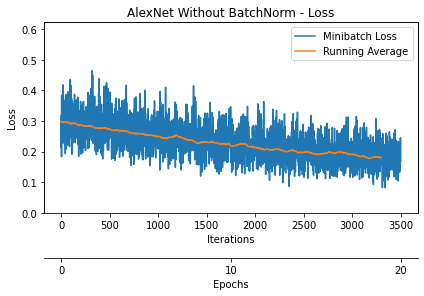

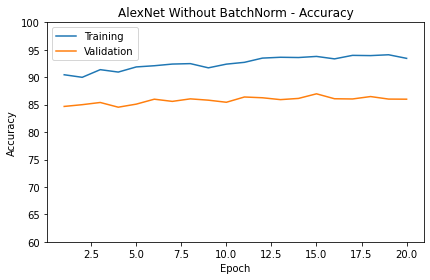

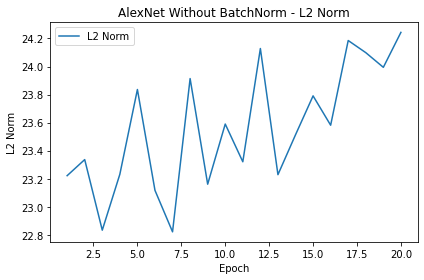

In [ ]:
minibatch_loss_list, train_acc_list, valid_acc_list, l2_norm_list = train_model(
    model=alexNetWithoutBatchNorm,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer1,
    device=DEVICE,
    scheduler=None,
    scheduler_on='valid_acc',
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)
plt.title('AlexNet Without BatchNorm - Loss')
plt.show()

plt.title('AlexNet Without BatchNorm - Accuracy')
plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()

plt.title('AlexNet Without BatchNorm - L2 Norm')
plot_l2norm(l2_norm_list)
plt.show()

Epoch: 001/020 | Batch 0000/0175 | Loss: 2.4582 
Epoch: 001/020 | Batch 0100/0175 | Loss: 1.3979 
Epoch: 001/020 | Train: 58.44% | Validation: 62.16% | L2 Norm:  83.23
Time elapsed: 1.55 min
Epoch: 002/020 | Batch 0000/0175 | Loss: 1.1992 
Epoch: 002/020 | Batch 0100/0175 | Loss: 0.8913 
Epoch: 002/020 | Train: 69.00% | Validation: 71.88% | L2 Norm:  60.99
Time elapsed: 3.05 min
Epoch: 003/020 | Batch 0000/0175 | Loss: 0.8016 
Epoch: 003/020 | Batch 0100/0175 | Loss: 0.7831 
Epoch: 003/020 | Train: 72.54% | Validation: 75.42% | L2 Norm:  53.51
Time elapsed: 4.55 min
Epoch: 004/020 | Batch 0000/0175 | Loss: 0.6600 
Epoch: 004/020 | Batch 0100/0175 | Loss: 0.6174 
Epoch: 004/020 | Train: 75.64% | Validation: 76.70% | L2 Norm:  50.16
Time elapsed: 6.07 min
Epoch: 005/020 | Batch 0000/0175 | Loss: 0.6474 
Epoch: 005/020 | Batch 0100/0175 | Loss: 0.7223 
Epoch: 005/020 | Train: 77.42% | Validation: 77.60% | L2 Norm:  47.27
Time elapsed: 7.58 min
Epoch: 006/020 | Batch 0000/0175 | Loss: 0.63

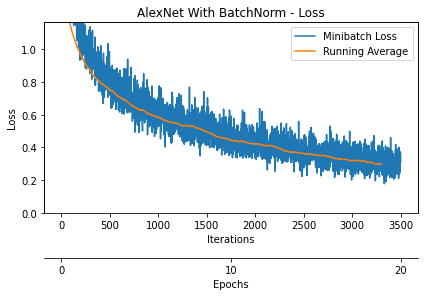

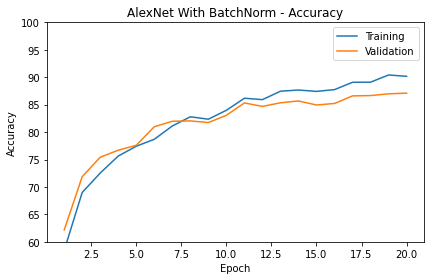

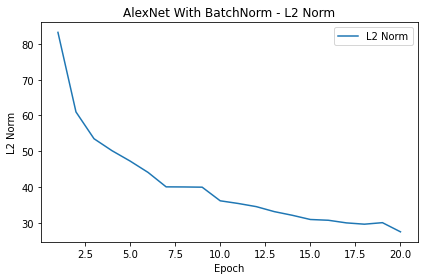

In [ ]:
minibatch_loss_list, train_acc_list, valid_acc_list, l2_norm_list = train_model(
    model=alexNetWithBatchNorm,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer2,
    device=DEVICE,
    scheduler=None,
    scheduler_on='valid_acc',
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)
plt.title('AlexNet With BatchNorm - Loss')
plt.show()

plt.title('AlexNet With BatchNorm - Accuracy')
plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()

plt.title('AlexNet With BatchNorm - L2 Norm')
plot_l2norm(l2_norm_list)
plt.show()

# 2. Residual connections (2 points)

Please make use of the model code from Homework 5 question 2 as you work on this question.

If your model didn't use residual connections, add them. If it already had residual connections, remove them. How does the performance change? Please experiment with applying residual connections around different blocks, where a block is a subset of layers (for example, add a residual connection around a single convolution/nonlinearity combination, or a residual connection around two convolution/nonlinearity combinations). Note that you may need to add 1x1 convolutions in the residual path if your block changes the shape (spatial or number of channels) of the input.

#Residual Connections
## With residual connections, the vanishing gradient problem is avoided and the network learns faster providing much better accuracy.

Epoch: 001/020 | Batch 0000/0175 | Loss: 3.0536 
Epoch: 001/020 | Batch 0100/0175 | Loss: 1.4471 
Epoch: 001/020 | Train: 60.92% | Validation: 63.62% | L2 Norm:  94.49
Time elapsed: 1.78 min
Epoch: 002/020 | Batch 0000/0175 | Loss: 1.0094 
Epoch: 002/020 | Batch 0100/0175 | Loss: 0.8896 
Epoch: 002/020 | Train: 71.41% | Validation: 73.24% | L2 Norm:  64.11
Time elapsed: 3.41 min
Epoch: 003/020 | Batch 0000/0175 | Loss: 0.7221 
Epoch: 003/020 | Batch 0100/0175 | Loss: 0.5269 
Epoch: 003/020 | Train: 76.83% | Validation: 77.46% | L2 Norm:  61.77
Time elapsed: 5.04 min
Epoch: 004/020 | Batch 0000/0175 | Loss: 0.6274 
Epoch: 004/020 | Batch 0100/0175 | Loss: 0.4701 
Epoch: 004/020 | Train: 81.46% | Validation: 82.36% | L2 Norm:  53.40
Time elapsed: 6.67 min
Epoch: 005/020 | Batch 0000/0175 | Loss: 0.4852 
Epoch: 005/020 | Batch 0100/0175 | Loss: 0.5492 
Epoch: 005/020 | Train: 82.93% | Validation: 82.12% | L2 Norm:  53.06
Time elapsed: 8.30 min
Epoch: 006/020 | Batch 0000/0175 | Loss: 0.44

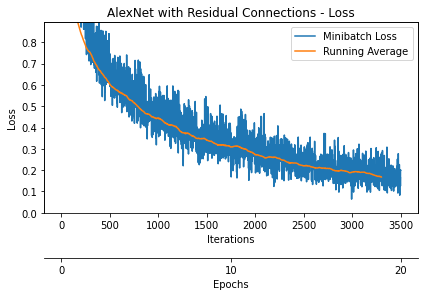

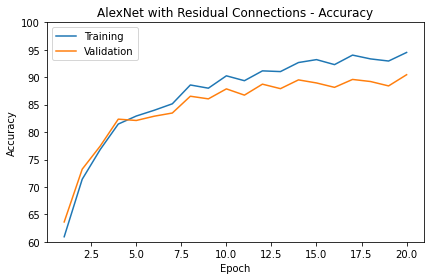

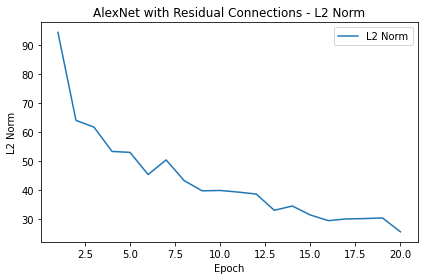

In [11]:
minibatch_loss_list, train_acc_list, valid_acc_list, l2_norm_list = train_model(
    model=alexResidualNet,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer3,
    device=DEVICE,
    scheduler=None,
    scheduler_on='valid_acc',
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)
plt.title('AlexNet with Residual Connections - Loss')
plt.show()

plt.title('AlexNet with Residual Connections - Accuracy')
plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()

plt.title('AlexNet with Residual Connections - L2 Norm')
plot_l2norm(l2_norm_list)
plt.show()

In [12]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = alexResidualNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))   

Accuracy of the network on the 10000 test images: 89.14 %


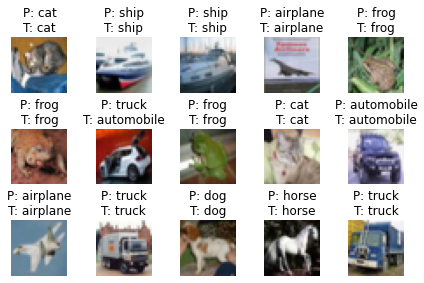

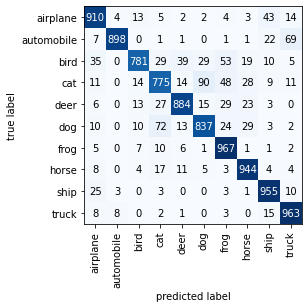

In [13]:
alexResidualNet.cpu()
unnormalizer = UnNormalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

show_examples(model=alexResidualNet, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)
mat = compute_confusion_matrix(model=alexResidualNet, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()